<a href="https://colab.research.google.com/github/Shuvro-Ahmed/Temporal-Fusion-Transformer-CO2-emission-BD/blob/main/TFT_CO2_BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==2.0.1+cu118 pytorch-lightning==2.0.2 pytorch_forecasting==1.0.0
!pip install --upgrade pytorch-lightning

ERROR: Could not find a version that satisfies the requirement torch==2.0.1+cu118 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0)
ERROR: No matching distribution found for torch==2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 66.3 MB/s eta 0:00:00


In [ ]:
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from sklearn.model_selection import train_test_split

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
df = pd.read_csv('/content/export_emissions BD.csv', sep='\t')
# df.index = pd.to_datetime(df.index)
# df.sort_index(inplace=True)
df.head(5)

,Date,Bangladesh
0,1960,2.2119
1,1961,2.2904
2,1962,2.5168
3,1963,2.8932
4,1964,2.9746


In [ ]:
# Convert 'Date' column to datetime
df['Year'] = df['Date'].copy()
df['Date'] = pd.to_datetime(df['Date'], format='%Y')

In [ ]:
# Set 'Date' as index for time series analysis
df.set_index('Date', inplace=True)

Skewnewss of Target column

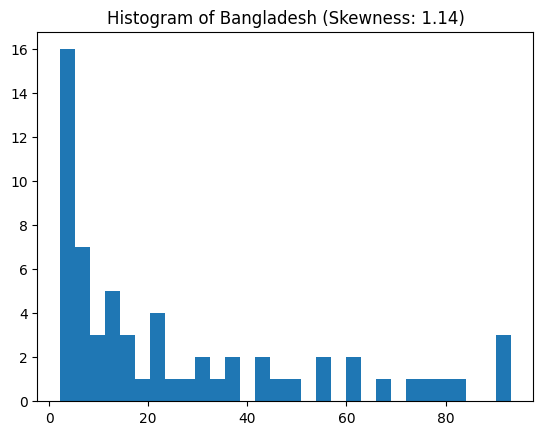

Skewness of Bangladesh: 1.14


In [ ]:
from scipy.stats import skew

# Define a list of column names to calculate skewness for
column_to_check = ['Bangladesh']
for column in column_to_check:
    # Calculate skewness for the current column
    skewness = skew(df[column].dropna())  # Dropna to handle potential NaN values

    # Visualize the histogram of the current column
    plt.hist(df[column].dropna(), bins=30)
    plt.title(f"Histogram of {column} (Skewness: {skewness:.2f})")
    plt.show()

    # Print the skewness value
    print(f"Skewness of {column}: {skewness:.2f}")

Data Transformation

In [ ]:
#Log Transformation
df['Bangladesh_log'] = np.log(df['Bangladesh'])
#Square Root Transformation
df['Bangladesh_sqrt'] = np.sqrt(df['Bangladesh'])
#Box-Cox Transformation
from scipy import stats
transformed_data, lambda_value = stats.boxcox(df['Bangladesh'])
df['Bangladesh_boxcox'] = transformed_data
#The lambda_value parameter will indicate the transformation applied. If lambda_value is close to 1, it's similar to a logarithmic transformation.

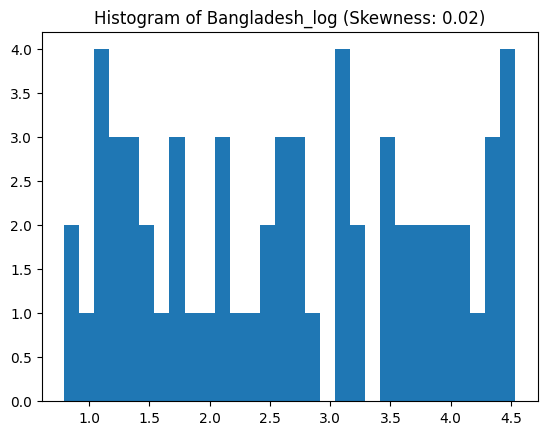

Skewness of Bangladesh_log: 0.02


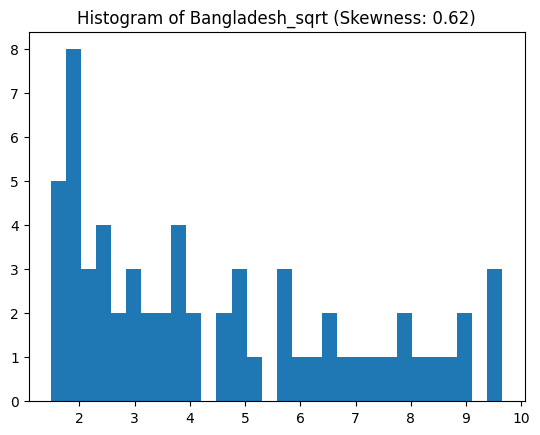

Skewness of Bangladesh_sqrt: 0.62


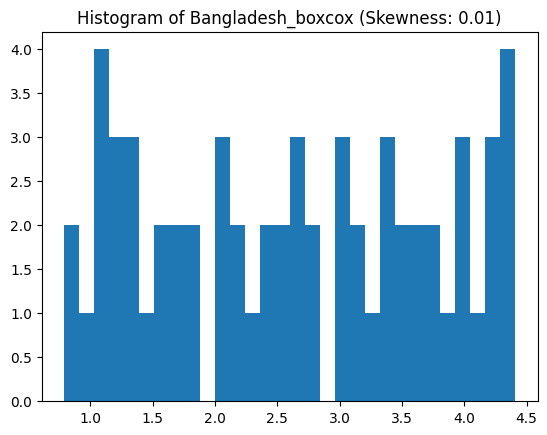

Skewness of Bangladesh_boxcox: 0.01


In [ ]:
from scipy.stats import skew

# Define a list of column names to calculate skewness for
column_to_check = ['Bangladesh_log', 'Bangladesh_sqrt', 'Bangladesh_boxcox']
for column in column_to_check:
    # Calculate skewness for the current column
    skewness = skew(df[column].dropna())  # Dropna to handle potential NaN values

    # Visualize the histogram of the current column
    plt.hist(df[column].dropna(), bins=30)
    plt.title(f"Histogram of {column} (Skewness: {skewness:.2f})")
    plt.show()

    # Print the skewness value
    print(f"Skewness of {column}: {skewness:.2f}")

In [ ]:
print(lambda_value)

-0.012580370322229773


Skewness of Bangladesh_log: 0.02
Skewness of Bangladesh_sqrt: 0.62
Skewness of Bangladesh_boxcox: 0.01
Lambda value for Box-Cox transformation: -0.012580370322229773
The Box-Cox transformation (Bangladesh_boxcox) resulted in the lowest skewness value, which is the closest to zero. Additionally, the lambda value for the Box-Cox transformation is very close to zero, indicating that the transformation is quite similar to a logarithmic transformation.

A skewness value of 0.01 is very close to zero and suggests that the data is now nearly normally distributed, making it a suitable choice for most statistical analyses and modeling techniques that assume normality.

Therefore, based on the provided information, the Box-Cox transformation (Bangladesh_boxcox) should be the definitive choice for transforming the 'Bangladesh' data to reduce skewness and make it closer to a normal distribution

In [ ]:
#drop
df = df.drop(["Bangladesh_log","Bangladesh_sqrt"], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Bangladesh         62 non-null     float64
 1   Year               62 non-null     int64  
 2   Bangladesh_boxcox  62 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.9 KB


In [ ]:
def summary(df):
    print(f"Dataset has {df.shape[1]} features and {df.shape[0]} examples.")
    summary = pd.DataFrame(index=df.columns)
    summary["Unique"] = df.nunique().values #nunique() returns the count of unique values.
    summary["Missing"] = df.isnull().sum().values
    summary["Duplicated"] = df.duplicated().sum()
    summary["Types"] = df.dtypes
    return summary

summary(df)

Dataset has 3 features and 62 examples.


,Unique,Missing,Duplicated,Types
Bangladesh,62,0,0,float64
Year,62,0,0,int64
Bangladesh_boxcox,62,0,0,float64


In [ ]:
df.describe()

,Bangladesh,Year,Bangladesh_boxcox
count,62.000000,62.000000,62.000000
mean,26.372216,1990.500000,2.630382
std,26.995994,18.041619,1.119650
min,2.211900,1960.000000,0.789901
25%,5.031475,1975.250000,1.597684
50%,14.411800,1990.500000,2.623511
75%,40.686050,2005.750000,3.619913
max,93.175900,2021.000000,4.407578


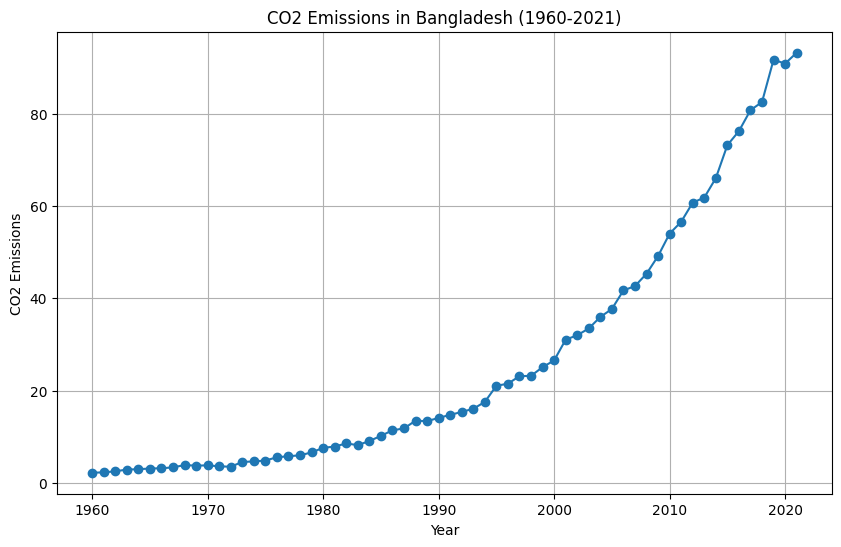

In [ ]:
# Line plot of CO2 emissions over time
plt.figure(figsize=(10, 6))
plt.plot(df['Bangladesh'], marker='o')
plt.title('CO2 Emissions in Bangladesh (1960-2021)')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.grid(True)
plt.show()

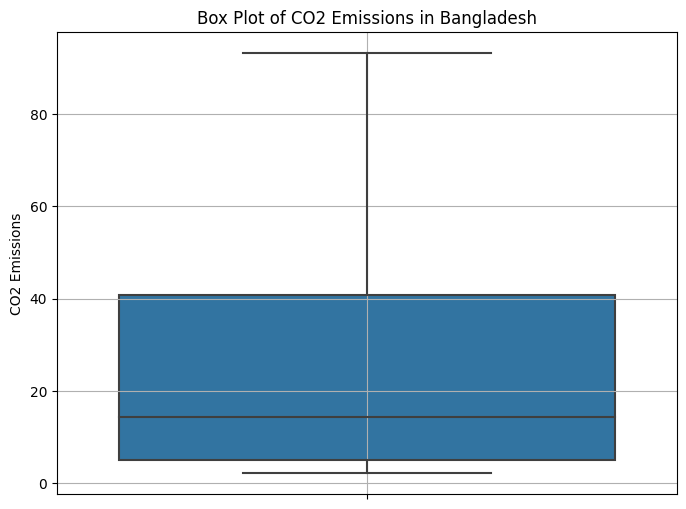

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='Bangladesh')
plt.title('Box Plot of CO2 Emissions in Bangladesh')
plt.ylabel('CO2 Emissions')
plt.grid(True)
plt.show()

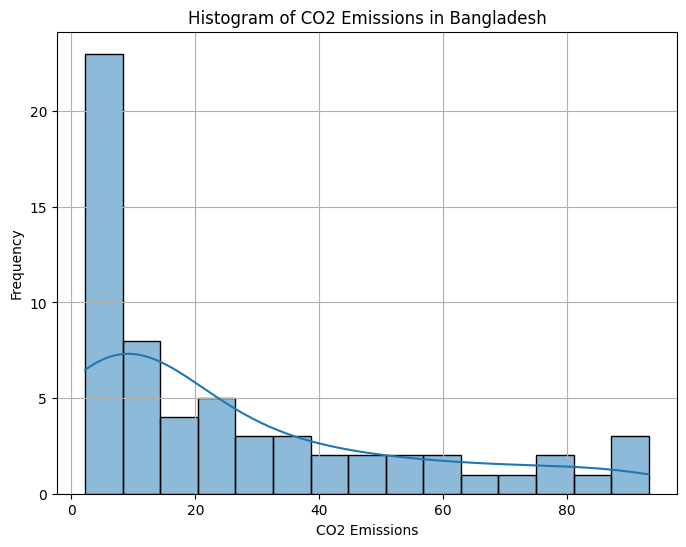

In [ ]:
#Histogram and Distribution:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Bangladesh', bins=15, kde=True)
plt.title('Histogram of CO2 Emissions in Bangladesh')
plt.xlabel('CO2 Emissions')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

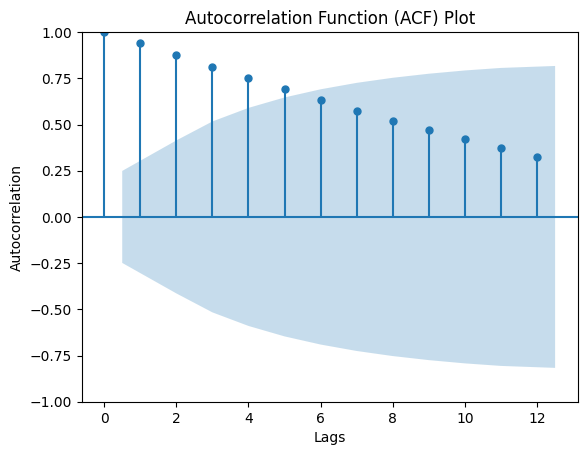

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(10, 6))
plot_acf(df['Bangladesh'], lags=12)  # You can adjust the number of lags to show in the plot
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()

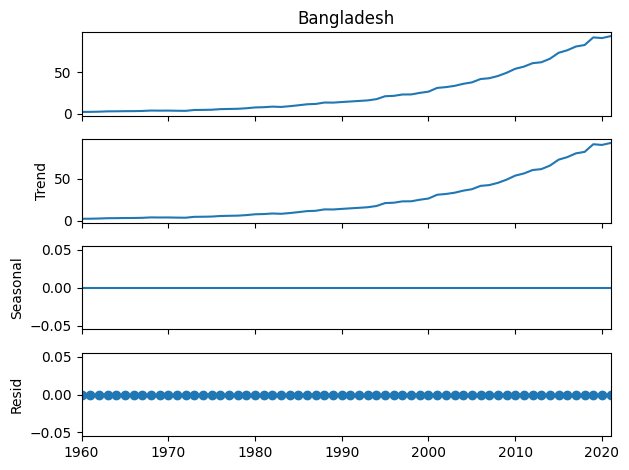

In [ ]:
#Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Bangladesh'], model='additive')
result.plot()
plt.show()
# df['trend'] = result.trend
# df['seasonal'] = result.seasonal

In [ ]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

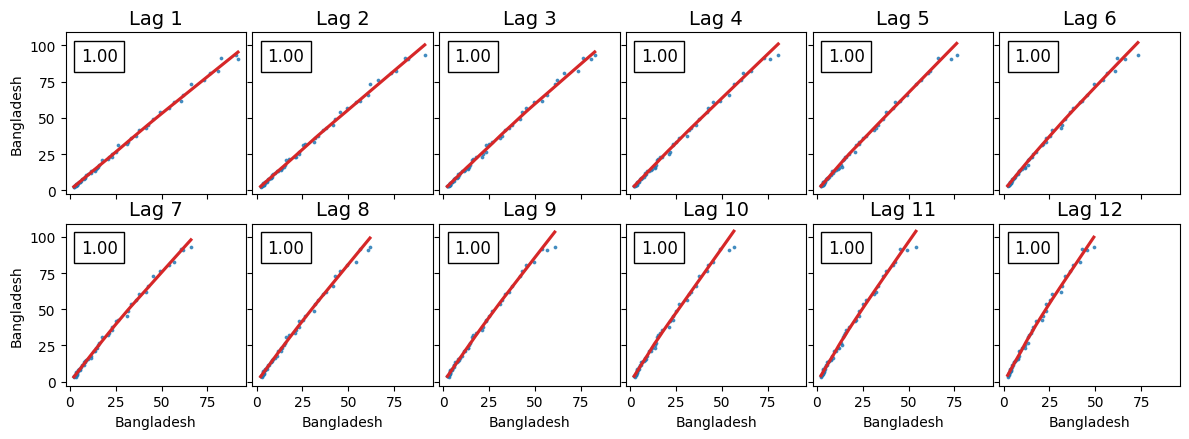

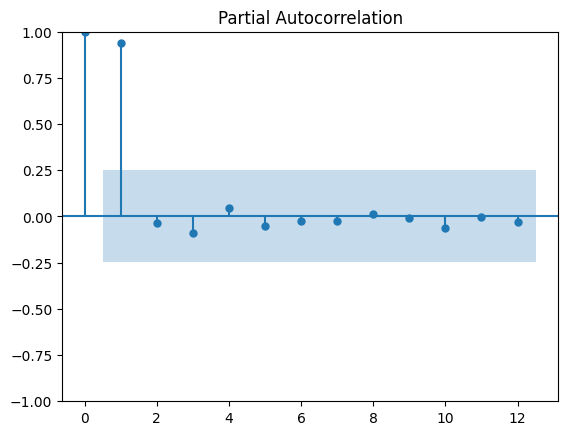

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
_ = plot_lags(df.Bangladesh, lags=12, nrows=2)
_ = plot_pacf(df.Bangladesh, lags=12)

In [ ]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


lag_col = make_lags(df.Bangladesh, lags=1)
lag_col = lag_col.fillna(0.0)
lag_col

,y_lag_1
Date,
1960-01-01,0.0000
1961-01-01,2.2119
1962-01-01,2.2904
1963-01-01,2.5168
1964-01-01,2.8932
...,...
2017-01-01,76.1935
2018-01-01,80.7312
2019-01-01,82.4937


In [ ]:
#Statistical Tests
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test for stationarity
result_adf = adfuller(df['Bangladesh'])
print("ADF Statistic:", result_adf[0])
print("p-value:", result_adf[1])
print("Critical Values:", result_adf[4])

ADF Statistic: -2.8831433948883176
p-value: 0.047343598632669834
Critical Values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}


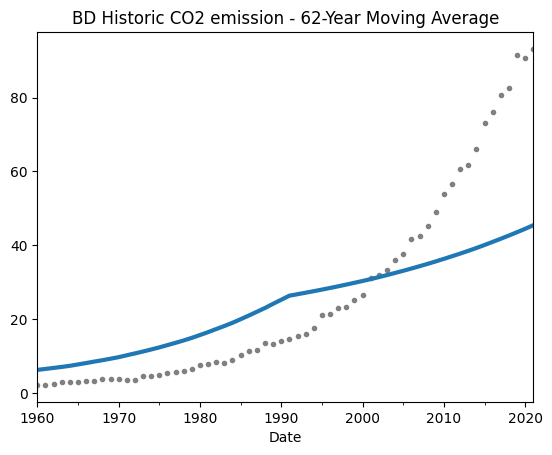

In [ ]:
df_temp = df['Bangladesh']
moving_average = df_temp.rolling(
    window=62,        # 62-Year window
    center=True,      # puts the average at the center of the window
    min_periods=31,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df_temp.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="BD Historic CO2 emission - 62-Year Moving Average", legend=False,
);

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df_temp.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend,trend_squared
Date,,,
1960-01-01,1.0,1.0,1.0
1961-01-01,1.0,2.0,4.0
1962-01-01,1.0,3.0,9.0
1963-01-01,1.0,4.0,16.0
1964-01-01,1.0,5.0,25.0


In [ ]:
from sklearn.linear_model import LinearRegression

y = df_temp  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

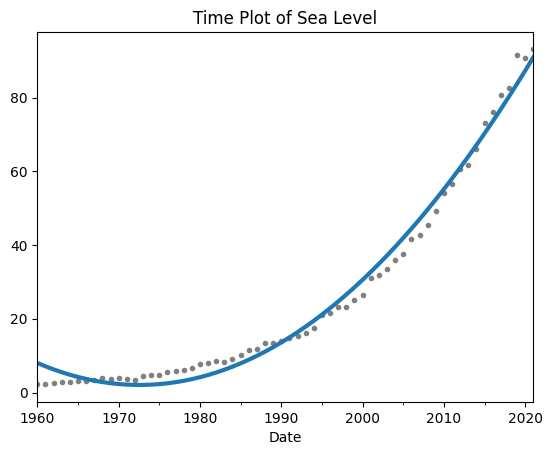

In [ ]:
ax = df_temp.plot(style=".", color="0.5", title="Time Plot of Sea Level")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [ ]:
# Correlation Analysis
correlation = np.corrcoef(df.index.year, df['Bangladesh'])[0, 1]
print(f"Correlation between Date and CO2 Emissions: {correlation:.2f}")

Correlation between Date and CO2 Emissions: 0.91


In [ ]:
# Add the 'id' column and set its value to 0 for every row
df['id'] = 0

In [ ]:
# Add a new column 'time_step' starting from 0 and incrementing for each observation
df['time_idx'] = range(len(df))

In [ ]:
# df['const'] = X['const']
# df['trend'] = X['trend']
df['trend_squared'] = X['trend_squared']
# df['lag'] = lag_col['y_lag_1']

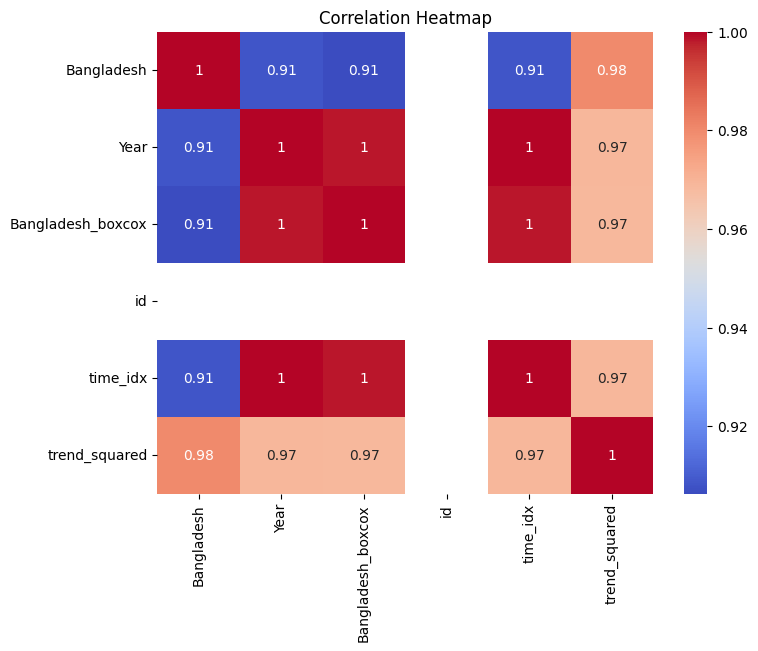

In [ ]:
import seaborn as sns
# Correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
#drop
df = df.drop(["Bangladesh_boxcox"], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Bangladesh     62 non-null     float64
 1   Year           62 non-null     int64  
 2   id             62 non-null     int64  
 3   time_idx       62 non-null     int64  
 4   trend_squared  62 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 2.9 KB


In [ ]:
# idx_train, idx_test = train_test_split(
#     df.index, test_size=12, shuffle=False,
# )
# data = df.loc[idx_train, :]

In [ ]:
max_prediction_length = 12
max_encoder_length = 50

training_cutoff = df['time_idx'].max() - max_prediction_length
# training_cutoff = 15146 - 365
# filtered_data = df[df['time_idx'].apply(lambda x: x <= training_cutoff)]
training = TimeSeriesDataSet(
    #data[lambda x: x.time_idx <= training_cutoff],
    # data = filtered_data,
    # data,
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Bangladesh",
    group_ids=["id"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    #static_categoricals=["consumer_id"],
    time_varying_known_reals=['Year', 'trend_squared', 'time_idx'],
    time_varying_unknown_reals=['Bangladesh'],
    target_normalizer=GroupNormalizer(
        groups=["id"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 128
# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=2)

In [ ]:
print(len(training))

49


In [ ]:
training.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
0,0,49,1,0,0,50,0,49,50
1,0,49,1,1,1,50,0,49,49
2,0,49,1,2,2,50,0,49,48
3,0,49,1,3,3,50,0,49,47
4,0,49,1,4,4,50,0,49,46
5,0,49,1,5,5,50,0,49,45
6,0,49,1,6,6,50,0,49,44
7,0,49,1,7,7,50,0,49,43
8,0,49,1,8,8,50,0,49,42
9,0,49,1,9,9,50,0,49,41


In [ ]:
validation.index

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
0,0,61,1,0,0,62,0,61,62


In [ ]:
#baseline model
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)]).to("cuda")
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


24.793424606323242

Find optimal learning rate

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    enable_model_summary=True,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42


Number of parameters in network: 8.4k


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:72: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: Learning rate set to 0.33884415613920277
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.33884415613920277


suggested learning rate: 0.33884415613920277


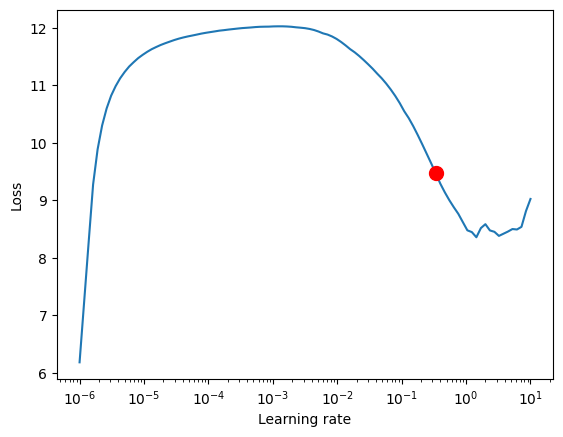

In [ ]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

Training the Temporal Fusion Transformer Model
9%

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=20, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.33884415613920277, #0.5 best till now
    hidden_size=8,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 128   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initia

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved. New best score: 59.822
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 59.822


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 1.425 >= min_delta = 0.0001. New best score: 58.396
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.425 >= min_delta = 0.0001. New best score: 58.396


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 4.416 >= min_delta = 0.0001. New best score: 53.980
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 4.416 >= min_delta = 0.0001. New best score: 53.980


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 3.086 >= min_delta = 0.0001. New best score: 50.894
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 3.086 >= min_delta = 0.0001. New best score: 50.894


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 2.694 >= min_delta = 0.0001. New best score: 48.200
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.694 >= min_delta = 0.0001. New best score: 48.200


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 2.433 >= min_delta = 0.0001. New best score: 45.768
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.433 >= min_delta = 0.0001. New best score: 45.768


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 2.075 >= min_delta = 0.0001. New best score: 43.692
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.075 >= min_delta = 0.0001. New best score: 43.692


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 2.394 >= min_delta = 0.0001. New best score: 41.298
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.394 >= min_delta = 0.0001. New best score: 41.298


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 2.568 >= min_delta = 0.0001. New best score: 38.730
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.568 >= min_delta = 0.0001. New best score: 38.730


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 2.685 >= min_delta = 0.0001. New best score: 36.046
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.685 >= min_delta = 0.0001. New best score: 36.046


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 2.986 >= min_delta = 0.0001. New best score: 33.060
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.986 >= min_delta = 0.0001. New best score: 33.060


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 1.859 >= min_delta = 0.0001. New best score: 31.201
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.859 >= min_delta = 0.0001. New best score: 31.201


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 3.582 >= min_delta = 0.0001. New best score: 27.618
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 3.582 >= min_delta = 0.0001. New best score: 27.618


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 3.295 >= min_delta = 0.0001. New best score: 24.323
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 3.295 >= min_delta = 0.0001. New best score: 24.323


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 2.575 >= min_delta = 0.0001. New best score: 21.748
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.575 >= min_delta = 0.0001. New best score: 21.748


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 0.465 >= min_delta = 0.0001. New best score: 21.283
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.465 >= min_delta = 0.0001. New best score: 21.283


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 1.863 >= min_delta = 0.0001. New best score: 19.420
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.863 >= min_delta = 0.0001. New best score: 19.420


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 2.414 >= min_delta = 0.0001. New best score: 17.006
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.414 >= min_delta = 0.0001. New best score: 17.006


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 1.805 >= min_delta = 0.0001. New best score: 15.201
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.805 >= min_delta = 0.0001. New best score: 15.201


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 0.978 >= min_delta = 0.0001. New best score: 14.223
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.978 >= min_delta = 0.0001. New best score: 14.223


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 0.474 >= min_delta = 0.0001. New best score: 13.748
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.474 >= min_delta = 0.0001. New best score: 13.748


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 0.611 >= min_delta = 0.0001. New best score: 13.137
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.611 >= min_delta = 0.0001. New best score: 13.137


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 1.106 >= min_delta = 0.0001. New best score: 12.031
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.106 >= min_delta = 0.0001. New best score: 12.031


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 0.956 >= min_delta = 0.0001. New best score: 11.075
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.956 >= min_delta = 0.0001. New best score: 11.075


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 0.749 >= min_delta = 0.0001. New best score: 10.326
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.749 >= min_delta = 0.0001. New best score: 10.326


Validation: 0it [00:00, ?it/s]

INFO: Metric val_loss improved by 0.407 >= min_delta = 0.0001. New best score: 9.918
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.407 >= min_delta = 0.0001. New best score: 9.918


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 20 records. Best score: 9.918. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 20 records. Best score: 9.918. Signaling Trainer to stop.


In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_3/checkpoints/epoch=70-step=71.ckpt


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [ ]:
!zip  -r BDmodeAsli9.zip lightning_logs/lightning_logs/version_3/checkpoints/epoch=70-step=71.ckpt

  adding: lightning_logs/lightning_logs/version_3/checkpoints/epoch=70-step=71.ckpt (deflated 58%)


Hyperparameter tuning

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=100,
    gradient_clip_val_range=(0.01, 1),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

In [ ]:
best_tft = TemporalFusionTransformer.load_from_checkpoint("/content/epoch=70-step=71.ckpt")

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [ ]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
MAE()(predictions.output, predictions.y)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(13.0542, device='cuda:0')

Check Tensorboard


In [ ]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2260), started 0:00:25 ago. (Use '!kill 2260' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
%reload_ext tensorboard

Model Evaluation

Get predictions on the validation set and calculate the average P50 (quantile median) loss:

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to('cuda')
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


13.054239273071289
tensor([13.0542], device='cuda:0')


Plot Predictions on Validation Data

If we pass the mode=raw on the predict() method, we get more information, including predictions for all seven quantiles. We also have access to the attention values (more about that later).


In [ ]:
#Take a look at what the raw_predictions variable contains

raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
#('output', 'x', 'index', 'decoder_lengths', 'y')

print('\n')
print(raw_predictions.output._fields)
# ('prediction',
# 'encoder_attention',
# 'decoder_attention',
# 'static_variables',
# 'encoder_variables',
# 'decoder_variables',
# 'decoder_lengths',
# 'encoder_lengths')

print('\n')
print(raw_predictions.output.prediction.shape)
#torch.Size([5, 24, 7])

# We get predictions of 5 time-series for 24 days.
# For each day we get 7 predictions - these are the 7 quantiles:
#[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# We are mostly interested in the 4th quantile which represents, let's say, the 'median loss'
# fyi, although docs use the term quantiles, the most accurate term are percentiles

# We get predictions of 5 time-series for 24 days.
# For each day we get 7 predictions - these are the 7 quantiles:
#[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# We are mostly interested in the 4th quantile which represents, let's say, the 'median loss'
# fyi, although docs use the term quantiles, the most accurate term are percentiles

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


('output', 'x', 'index', 'decoder_lengths', 'y')


('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([1, 12, 7])


We use the plot_prediction() to create our plots.

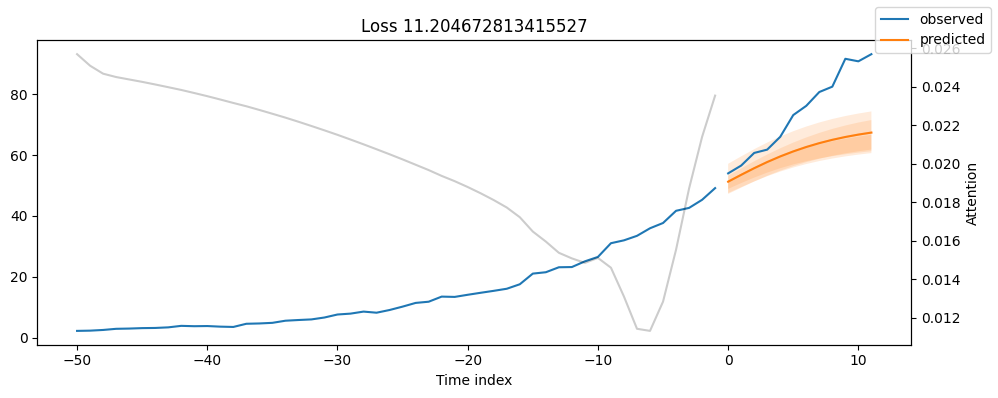

In [ ]:
for idx in range(1):  # plot all
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=QuantileLoss(),ax=ax)

Interpretable Forecasting

Accurate forecasting is one thing, but explainability also matters a lot nowadays.

And it’s even worse for Deep Learning models, which are considered black boxes. Methods such as LIME and SHAP can provide explainability (to some extent) but don’t work well for time-series. Plus, they are external post-hoc methods and are not tied to a particular model.

Temporal Fusion Transformer provides three types of interpretability:

Seasonality-wise: TFT leverages its novel Interpretable Multi-Head Attention mechanism to calculate the importance of past time steps.
Feature-wise: TFT leverages its Variable Selection Network module to calculate the importance of every feature.
Extreme events robustness: We can investigate how time series behave during rare events
If you want to learn in-depth about the inner workings of Interpretable Multi-Head Attention and Variable Selection Network, check my previous article.

Feature-wise Interpretability
The Variable Selection Network component of TFT can easily estimate the feature importances:

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x325 with 1 Axes>,
 'decoder_variables': <Figure size 700x300 with 1 Axes>}

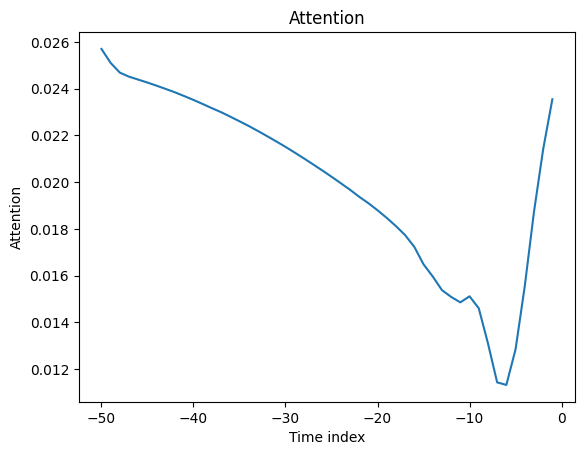

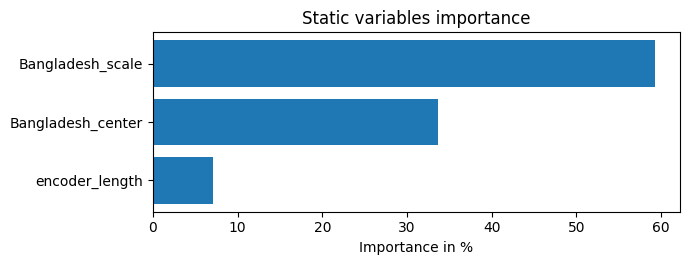

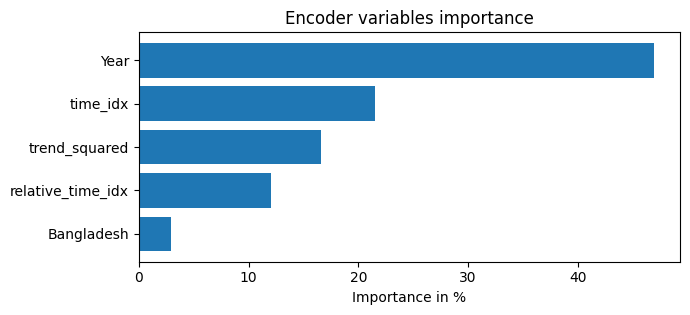

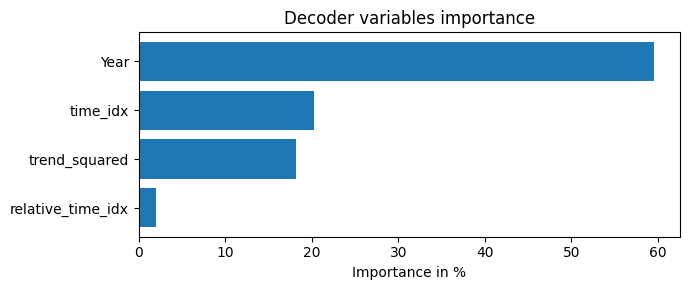

In [ ]:
raw_predictions= best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

Extreme Event Detection
Time series are notorious for being susceptible to sudden changes in their properties during rare events (also referred to as shocks).



With TFT, we can analyze the robustness of each individual feature across their range of values.

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Bangladesh_center': <Figure size 1000x500 with 2 Axes>,
 'Bangladesh_scale': <Figure size 1000x500 with 2 Axes>,
 'Year': <Figure size 1000x500 with 2 Axes>,
 'trend_squared': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'Bangladesh': <Figure size 1000x500 with 2 Axes>}

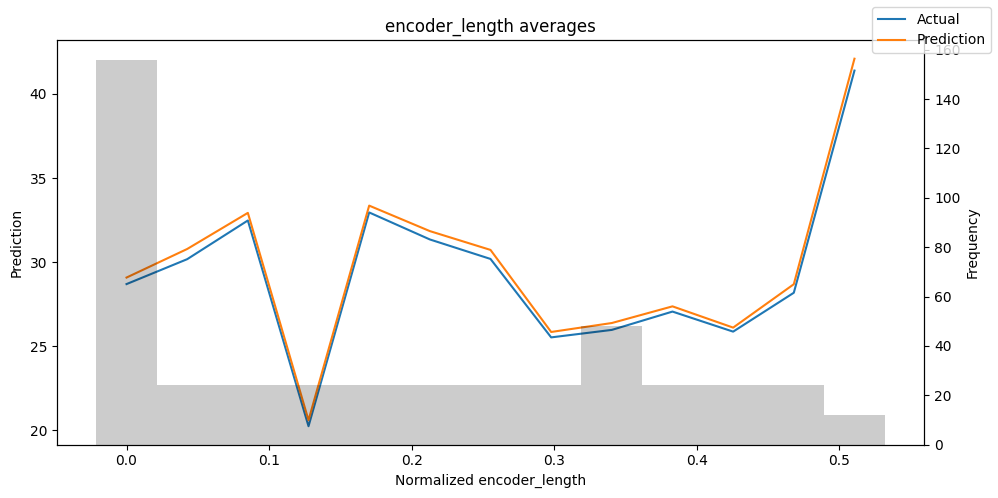

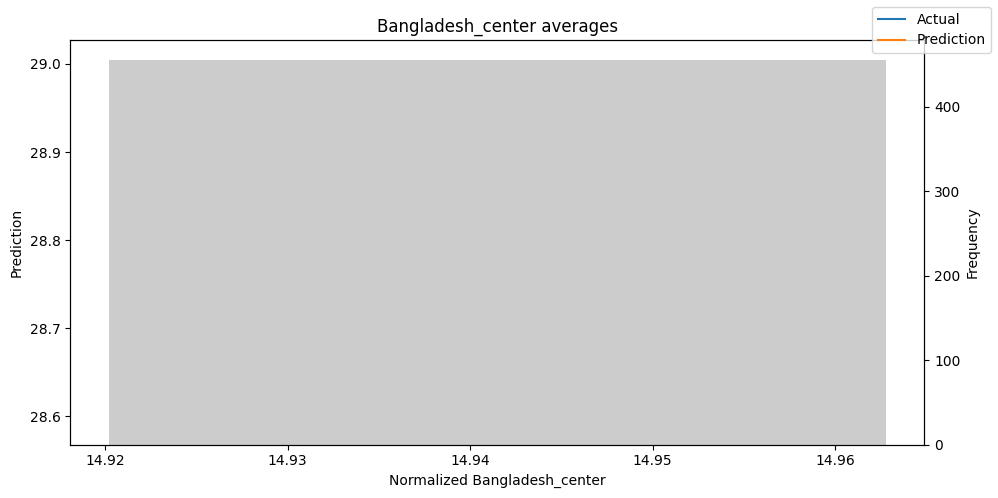

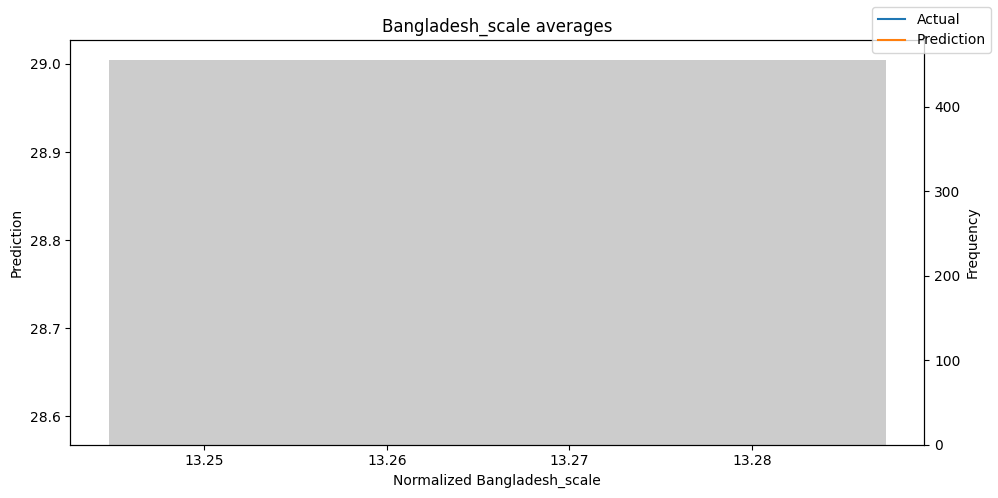

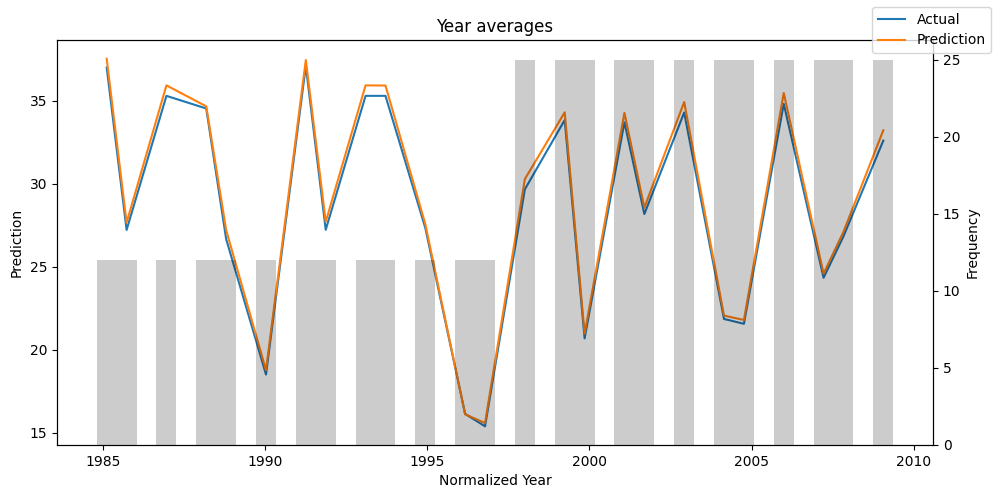

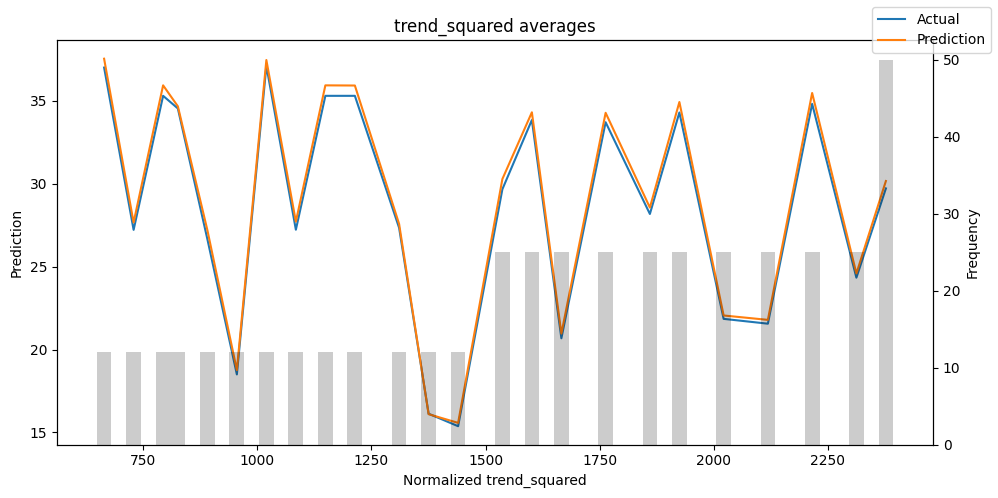

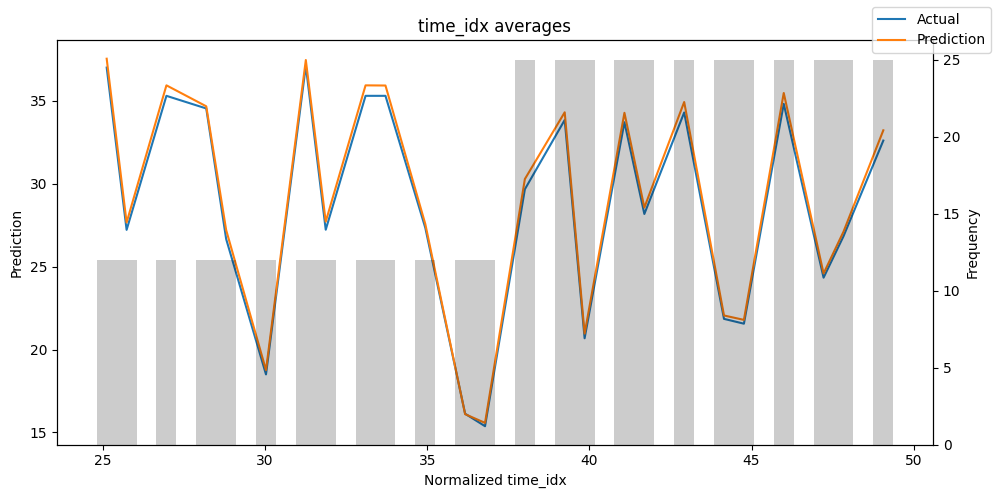

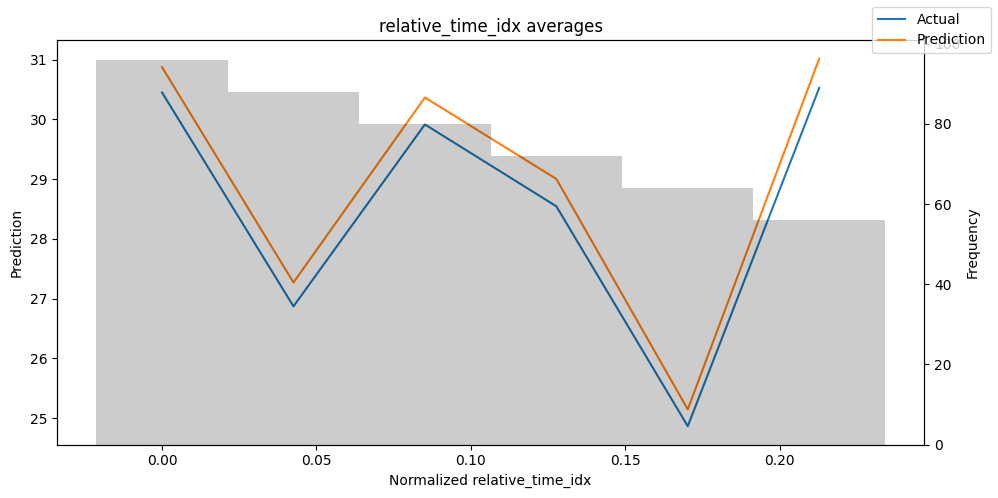

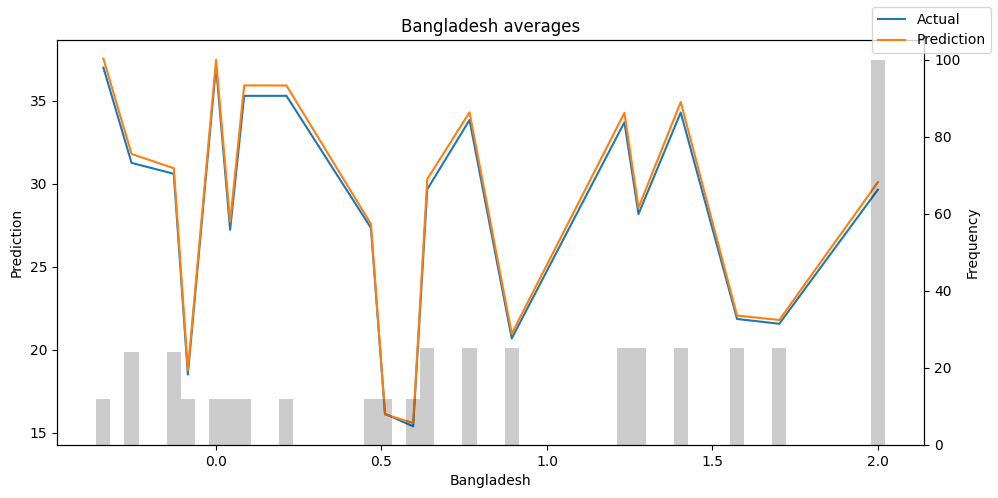

In [ ]:
#Analysis on the training set

predictions = best_tft.predict(train_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
# # Print the keys in the raw_predictions.x dictionary
# print("Keys in raw_predictions.x:", raw_predictions.x.keys())

# # Print the keys in the raw_predictions.output dictionary
# print("Keys in raw_predictions.output:", raw_predictions.output.keys())

In [ ]:
# # Assuming raw_predictions.x and raw_predictions.output are dictionaries
# # x_tensor = raw_predictions.x['your_key_for_x_tensor']
# output_tensor = raw_predictions.output['prediction']

# # Check the shapes of the tensors
# # print("Shape of x_tensor:", x_tensor.shape)
# print("Shape of output_tensor:", output_tensor.shape)

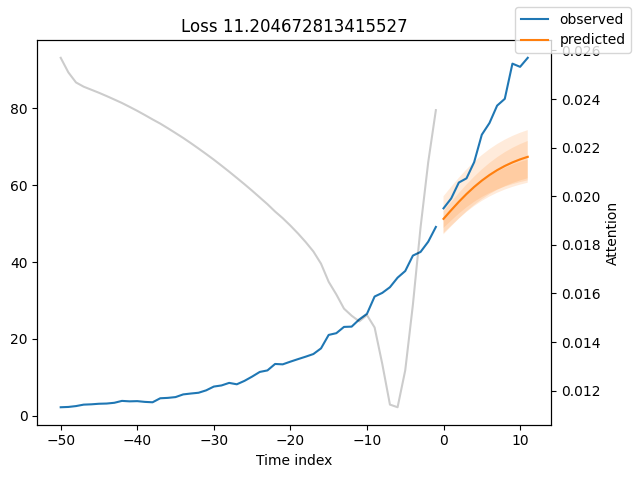

In [ ]:
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


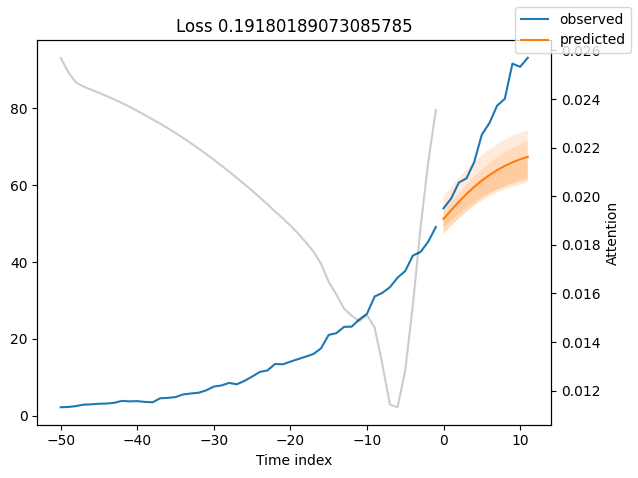

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader, return_y=True)
mean_losses = SMAPE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(1):  # plot 1
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

Actuals vs predictions by variables
Checking how the model performs across different slices of the data allows us to detect weaknesses. Plotted below are the means of predictions vs actuals across each variable divided into 100 bins using the Now, we can directly predict on the generated data using the calculate_prediction_actual_by_variable() and plot_prediction_actual_by_variable() methods. The gray bars denote the frequency of the variable by bin, i.e. are a histogram.

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'Bangladesh_center': <Figure size 1000x500 with 2 Axes>,
 'Bangladesh_scale': <Figure size 1000x500 with 2 Axes>,
 'Year': <Figure size 1000x500 with 2 Axes>,
 'trend_squared': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'Bangladesh': <Figure size 1000x500 with 2 Axes>}

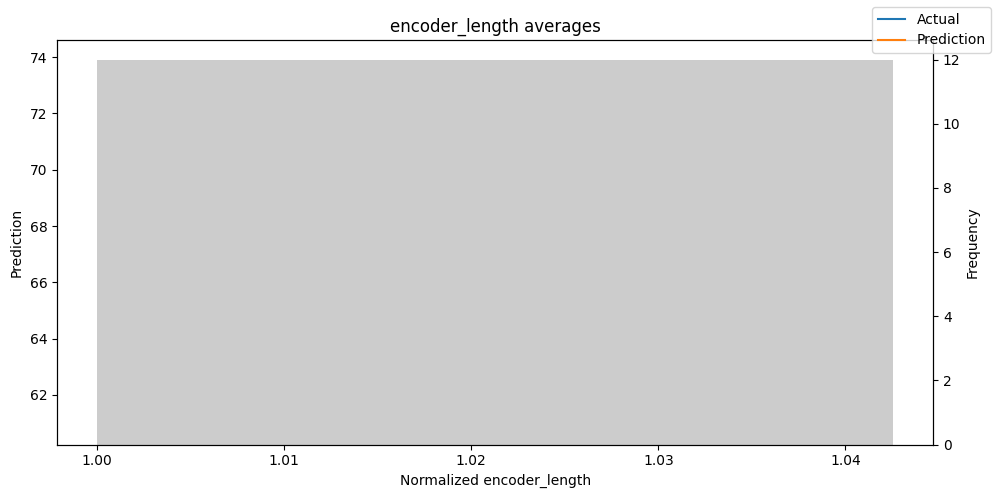

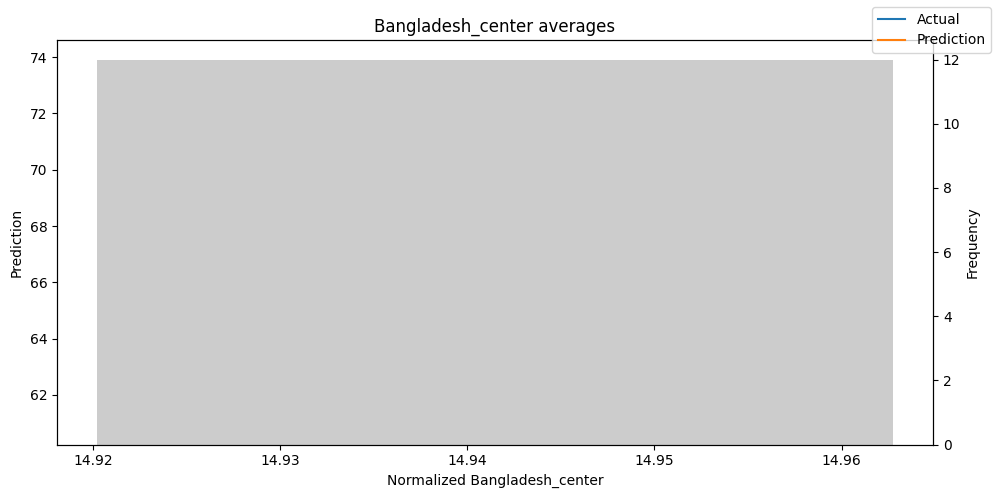

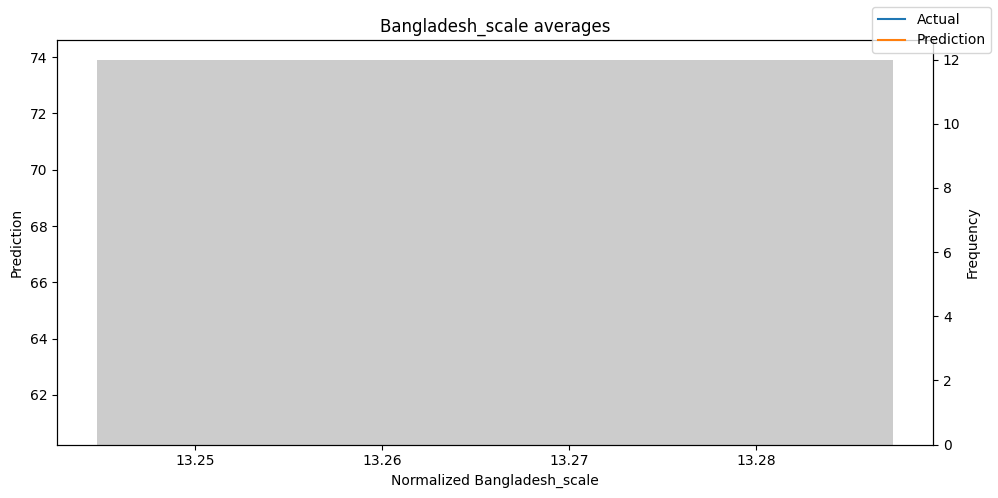

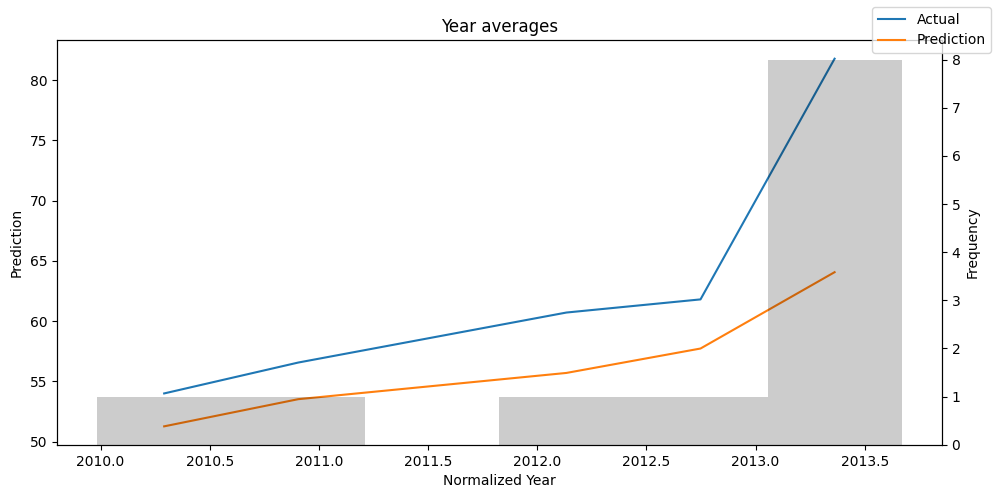

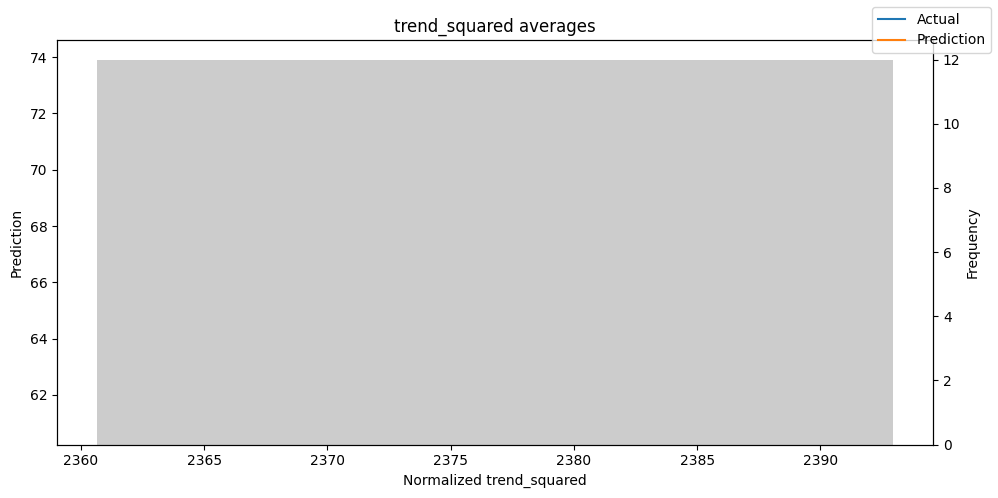

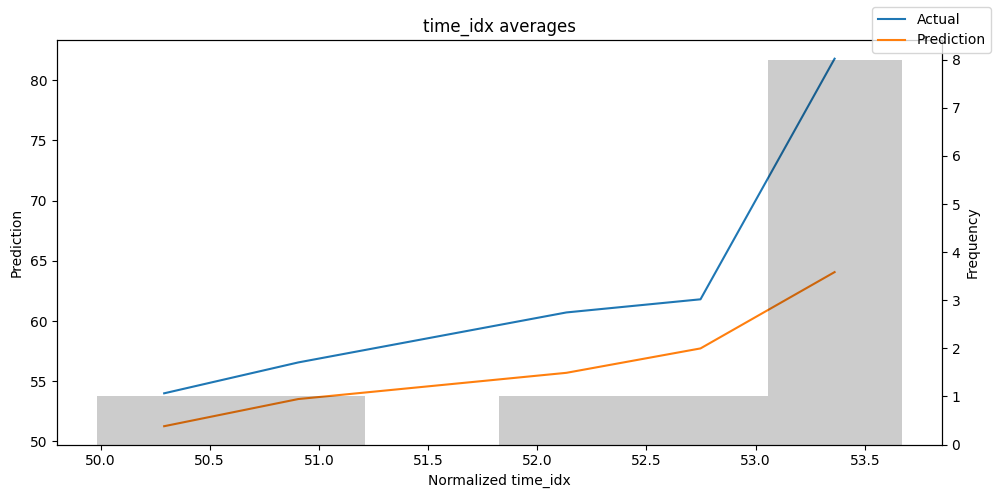

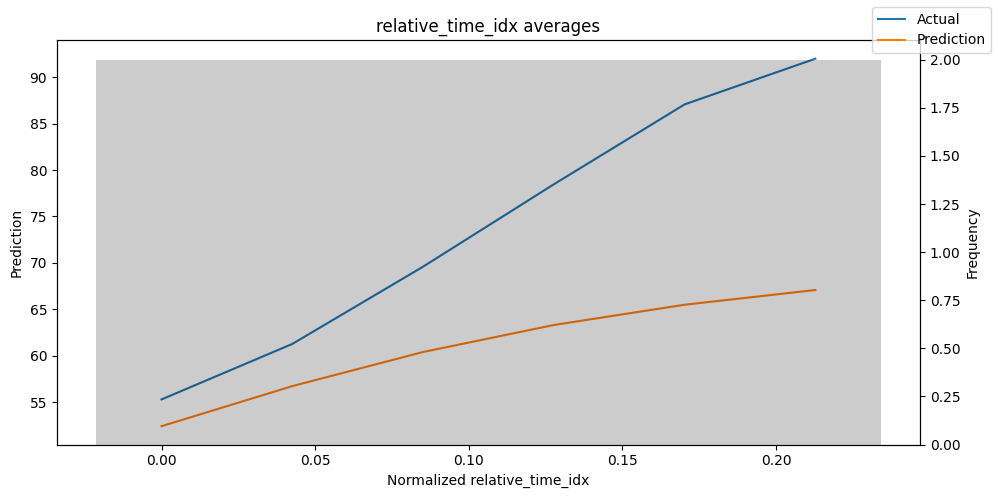

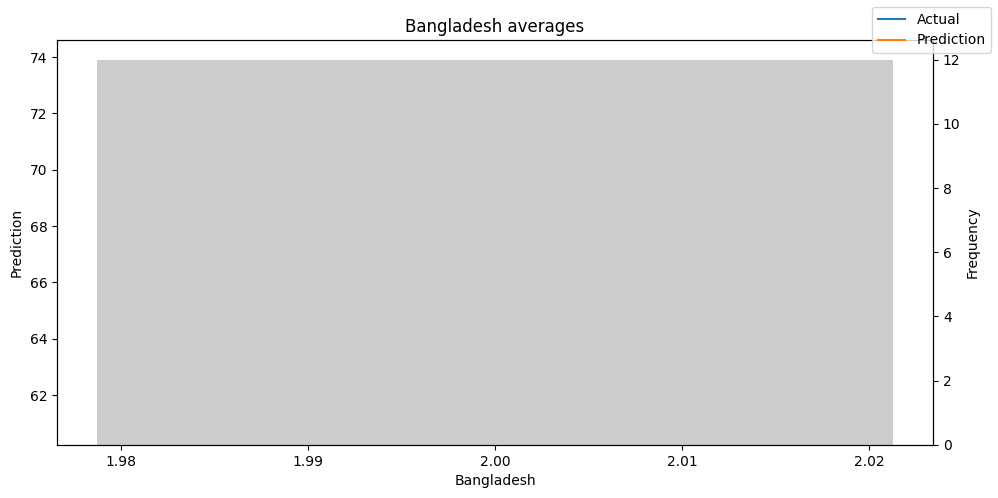

In [ ]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

Interpret model
Variable importances
The model has inbuilt interpretation capabilities due to how its architecture is build. Let’s see how that looks. We first calculate interpretations with interpret_output() and plot them subsequently with plot_interpretation().

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x325 with 1 Axes>,
 'decoder_variables': <Figure size 700x300 with 1 Axes>}

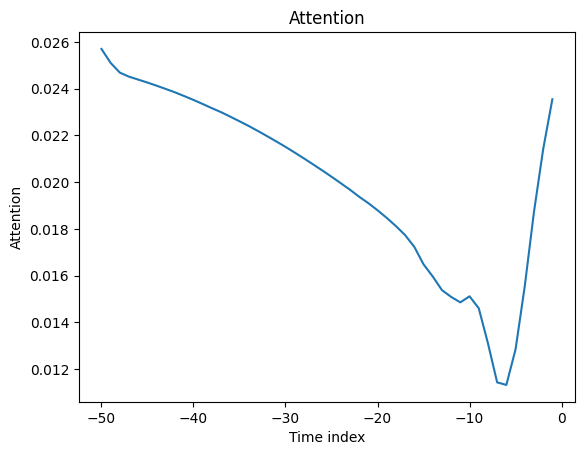

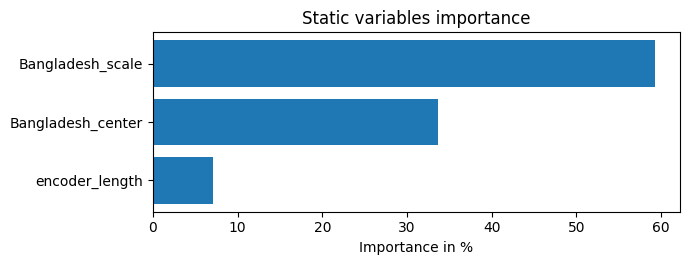

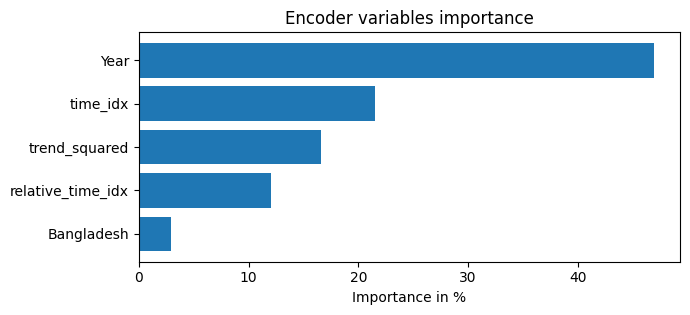

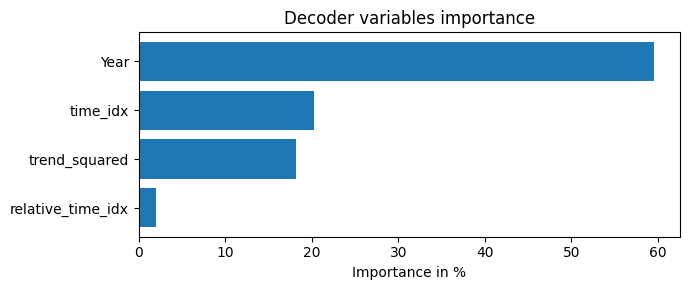

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)